# Covid Analysis

## Imports

In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix
from xgboost import XGBClassifier, callback
import shap, warnings, sys
import textwrap

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

## Config

In [2]:
CSV   = "data/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW_.csv"
THR   = 0.90          # ICU crisis threshold
LEAD  = 7             # NEW: 7-day forecast window
CUT   = pd.Timestamp("2022-07-01")   # time-aware split

## Load Data

In [3]:
df = (
    pd.read_csv(CSV, parse_dates=["date"])
      .dropna(subset=["adult_icu_bed_utilization"])
)

g = df.sort_values("date").groupby("state")

## Feature Engineering

In [4]:
df["icu_util_max_next7"] = (
    g["adult_icu_bed_utilization"]
      .shift(-LEAD).rolling(LEAD, min_periods=1).max()
)
df["breach_next7"] = (df["icu_util_max_next7"] >= THR).astype(int)
df = df.dropna(subset=["icu_util_max_next7"]).reset_index(drop=True)

In [5]:
BASE = [
    "adult_icu_bed_utilization",
    "inpatient_beds_utilization",
    "percent_of_inpatients_with_covid",
    "adult_icu_bed_covid_utilization",
]

for col in BASE:
    # Simple day-to-day change
    df[f"{col}_d1"] = g[col].diff()

    # Rolling means
    df[f"{col}_ma7"]   = g[col].transform(lambda s: s.rolling(7, 1).mean())
    df[f"{col}_ma14"]  = g[col].transform(lambda s: s.rolling(14, 1).mean())
    df[f"{col}_trend"] = df[f"{col}_ma7"] - df[f"{col}_ma14"]

    # NEW: explicit lag features
    for lag in (1, 3, 7, 14):
        df[f"{col}_lag{lag}"] = g[col].shift(lag)

NUMERIC = [
    c for c in df.columns
    if any(c.startswith(p) for p in BASE)
       or any(c.endswith(suf) for suf in ("_d1", "_ma7", "_ma14",
                                          "_trend", "_lag1", "_lag3",
                                          "_lag7", "_lag14"))
]
CAT   = ["state"]
FEATS = NUMERIC + CAT

## Train/Test

In [6]:
train, test = df[df.date < CUT], df[df.date >= CUT]
X_train, y_train = train[FEATS], train["breach_next7"]
X_test,  y_test  = test [FEATS],  test ["breach_next7"]

pos_rate  = y_train.mean()
scale_pos = (1 - pos_rate) / pos_rate
print(f"Train rows: {len(train):,}  |  Test rows: {len(test):,}")
print(f"Positive share: {pos_rate:0.2%}  →  scale_pos_weight={scale_pos:0.1f}")

Train rows: 38,217  |  Test rows: 18,636
Positive share: 14.66%  →  scale_pos_weight=5.8


## Preprocessor and XGBoost Model

In [7]:
pre = ColumnTransformer(
    [("num", "passthrough", NUMERIC),
     ("cat", OneHotEncoder(handle_unknown="ignore"), CAT)]
)

clf = XGBClassifier(
    n_estimators=1200,           # more trees
    max_depth=6,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    scale_pos_weight=scale_pos,
)

pipe = Pipeline([("pre", pre), ("clf", clf)])

# Adaptive early stopping
eval_set = [(pre.fit_transform(X_test), y_test)]
try:
    pipe.fit(
        X_train, y_train,
        clf__eval_set=eval_set,
        clf__callbacks=[callback.EarlyStopping(rounds=50, save_best=True, metric_name="auc")],
    )
except TypeError:
    try:
        pipe.fit(
            X_train, y_train,
            clf__eval_set=eval_set,
            clf__early_stopping_rounds=50,
            clf__verbose=False,
        )
    except TypeError:
        pipe.fit(X_train, y_train)


## Metrics

In [8]:
probs   = pipe.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, probs)
prec, rec, _ = precision_recall_curve(y_test, probs)
auc_pr  = auc(rec, prec)
rec75   = rec[prec >= 0.75].max()  # NEW: 75 % precision point

print(f"\nAUROC  : {auc_roc:0.3f}")
print(f"PR-AUC : {auc_pr :0.3f}")
print(f"Recall @ 75 % precision: {rec75:0.3f}")

print("\nConfusion matrix @ 0.5 threshold:")
print(confusion_matrix(y_test, probs > 0.5))


AUROC  : 0.606
PR-AUC : 0.060
Recall @ 75 % precision: 0.000

Confusion matrix @ 0.5 threshold:
[[17601   276]
 [  728    31]]


## SHAP

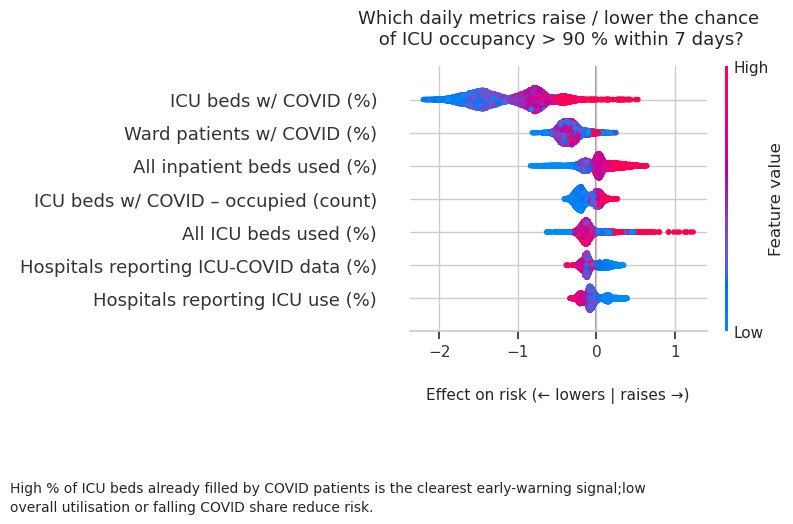

In [9]:
sample = X_test.sample(n=len(X_test), random_state=42)

X_trans  = pipe.named_steps["pre"].transform(sample)
raw_cols = pipe.named_steps["pre"].get_feature_names_out()

friendly = {
    # ───── Primary ratios (already in the chart) ──────────────────────
    "num__adult_icu_bed_covid_utilization"       : "ICU beds w/ COVID (%)",
    "num__percent_of_inpatients_with_covid"      : "Ward patients w/ COVID (%)",
    "num__inpatient_beds_utilization"            : "All inpatient beds used (%)",
    "num__adult_icu_bed_utilization"             : "All ICU beds used (%)",
    "num__adult_icu_bed_covid_utilization_numerator"   : "ICU beds w/ COVID – occupied (count)",
    "num__adult_icu_bed_covid_utilization_coverage"    : "Hospitals reporting ICU-COVID data (%)",
    "num__adult_icu_bed_utilization_coverage"    : "Hospitals reporting ICU use (%)",
}

feat_names = [friendly.get(c, c) for c in raw_cols]
explainer   = shap.TreeExplainer(pipe.named_steps["clf"])
shap_values = explainer.shap_values(X_trans)

shap.summary_plot(
    shap_values,
    features=X_trans,
    feature_names=feat_names,
    max_display=7,        # show only the 7 most influential drivers
    show=False,
)

plt.title("Which daily metrics raise / lower the chance\n of ICU occupancy > 90 % within 7 days?", fontsize=13, pad=16)
plt.xlabel("Effect on risk (← lowers | raises →)", fontsize=11, labelpad=20)

takeaway = (
    "High % of ICU beds already filled by COVID patients is the clearest early-warning signal;"
    "low overall utilisation or falling COVID share reduce risk."
)

plt.figtext(
    0.01, -0.14, textwrap.fill(takeaway, 95),
    ha="left", va="top", fontsize=10, wrap=True, linespacing=1.4,
    transform=plt.gcf().transFigure
)

plt.tight_layout()
plt.savefig("SHAP_features.png", bbox_inches="tight")
plt.show()

## Results

In [10]:
out = test[["state", "date", "adult_icu_bed_utilization"]].copy()
out["prob_breach_7d"] = probs
out.to_csv("icu_breach_probabilities.csv", index=False)

## Most Likely Outbreak Location

In [11]:
latest = out[out.date == out.date.max()]
top    = latest.sort_values("prob_breach_7d", ascending=False).iloc[0]
print(
    f"\n{latest.date.max():%Y-%m-%d} | State: {top.state}"
    f"\nICU utilisation today: {top.adult_icu_bed_utilization:0.1%}"
    f"\n7-day breach probability: {top.prob_breach_7d:0.1%}"
)


2023-06-11 | State: UT
ICU utilisation today: 60.0%
7-day breach probability: 6.1%
